In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

df = pd.read_csv("train.csv")
df

,Date,Open,High,Low,Close,Volume
0,2021-04-07,1099.59,1110.75,1093.85,1109.64,66545000
1,2016-01-05,1117.47,1130.57,1112.75,1125.85,41227200
2,2016-01-06,1116.63,1138.68,1116.10,1133.04,42316800
3,2016-01-07,1122.00,1149.76,1117.56,1143.37,64899600
4,2016-01-08,1145.64,1149.96,1120.93,1122.88,52138900
...,...,...,...,...,...,...
1650,2022-07-25,2412.25,2429.44,2387.41,2402.95,29106300
1651,2022-07-26,2289.29,2307.08,2255.66,2280.27,48503400
1652,2022-07-27,2309.14,2404.25,2296.82,2395.54,43790900
1653,2022-07-28,2385.58,2443.26,2377.34,2434.89,25807000


In [23]:
print(df.shape)
print(df.isna().sum())

(1655, 6)
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


TIME SERIES ANALYSIS

In [24]:
ts_df = pd.read_csv("train.csv")

ts_df['Date']=pd.to_datetime(ts_df['Date'])
ts_df = ts_df.set_index('Date')

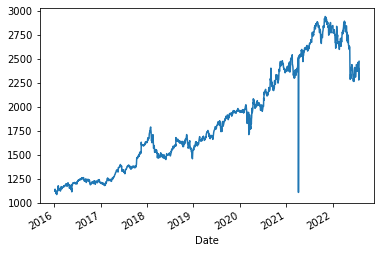

In [25]:

ts_df['Close'].plot()
plt.show()

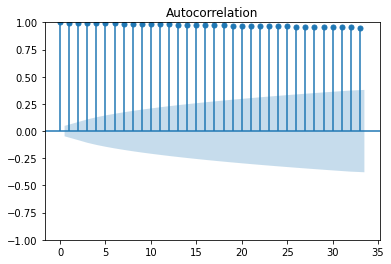

/home/pes2ug20cs419/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


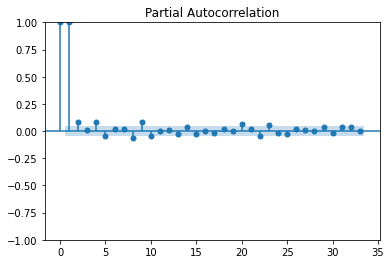

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_df['Close'])
plt.show()

plot_pacf(ts_df['Close'])
plt.show()

The data is not stationary.

In [27]:
import pmdarima as pm

model = pm.auto_arima(ts_df['Close'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=14979.327, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14976.354, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14969.302, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=14969.870, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14976.607, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=14968.164, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=14969.313, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=14971.291, Time=1.82 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=14968.854, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=14968.770, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=14968.731, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=14970.681, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=14968.782, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12] intercept
Total fit time: 6.778 sec

The best model is ARIMA(1,1,0)

In [28]:
train = ts_df[:1325]
test = ts_df[1325:1655]

model.fit(train['Close'])

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [29]:
forecast=model.predict(n_periods= 330, return_conf_int=True)

/home/pes2ug20cs419/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:
rms = mean_squared_error(test['Close'], forecast[0], squared=False)
rms

219.9405451786318

Next, we will attempt to use machine learning models to predict the closing price.

Feature Engineering in order to extract information from given attributes

In [31]:
test_df = pd.read_csv("test.csv")

df = df.append(test_df, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])

df['OHL'] =  df[['High', 'Low', 'Open']].mean(axis = 1)
df['MA7_O'] = df.rolling(window=7)['Open'].mean()
df['MA14_O'] = df.rolling(window=14)['Open'].mean()

df['Diff_O'] = df['Open'] - df['MA7_O']
df['Diff_O14'] = df['Open'] - df['MA14_O']

df['TR'] = df['High'] - df['Low']
df['HL'] = df['High'] * df['Low']

df['OHLstd'] = df[['Open','High','Low']].std(axis=1)
df['OHLskew'] = df[['Open','High','Low']].skew(axis=1)
df['wp'] = (df['Open']+ df['High']+ df['Low'])/3
df['Opos'] = (df['Open']-df['Low'])/(df['High']-df['Low']) -0.5


df['weekday'] = df['Date'].dt.weekday+1
df['Monday'] = np.where(df['weekday']==1,1,0)
df['Tuesday'] = np.where(df['weekday']==2,1,0)
df['Wednesday'] = np.where(df['weekday']==3,1,0)
df['Thursday'] = np.where(df['weekday']==4,1,0)
df['Friday'] = np.where(df['weekday']==5,1,0)

df['logVolume'] = np.log(df['Volume']+1)

df['Open_differenced'] = df['Open'].diff()
df['High_differenced'] = df['High'].diff()
df['Low_differenced'] = df['Low'].diff()

train_df = df[:1655]
test_df = df[1655:1690]

train_df.dropna(inplace = True)



<ipython-input-31-5538699a18c7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace = True)


Correlogram to find the attributes that affect the closing price to a large extent

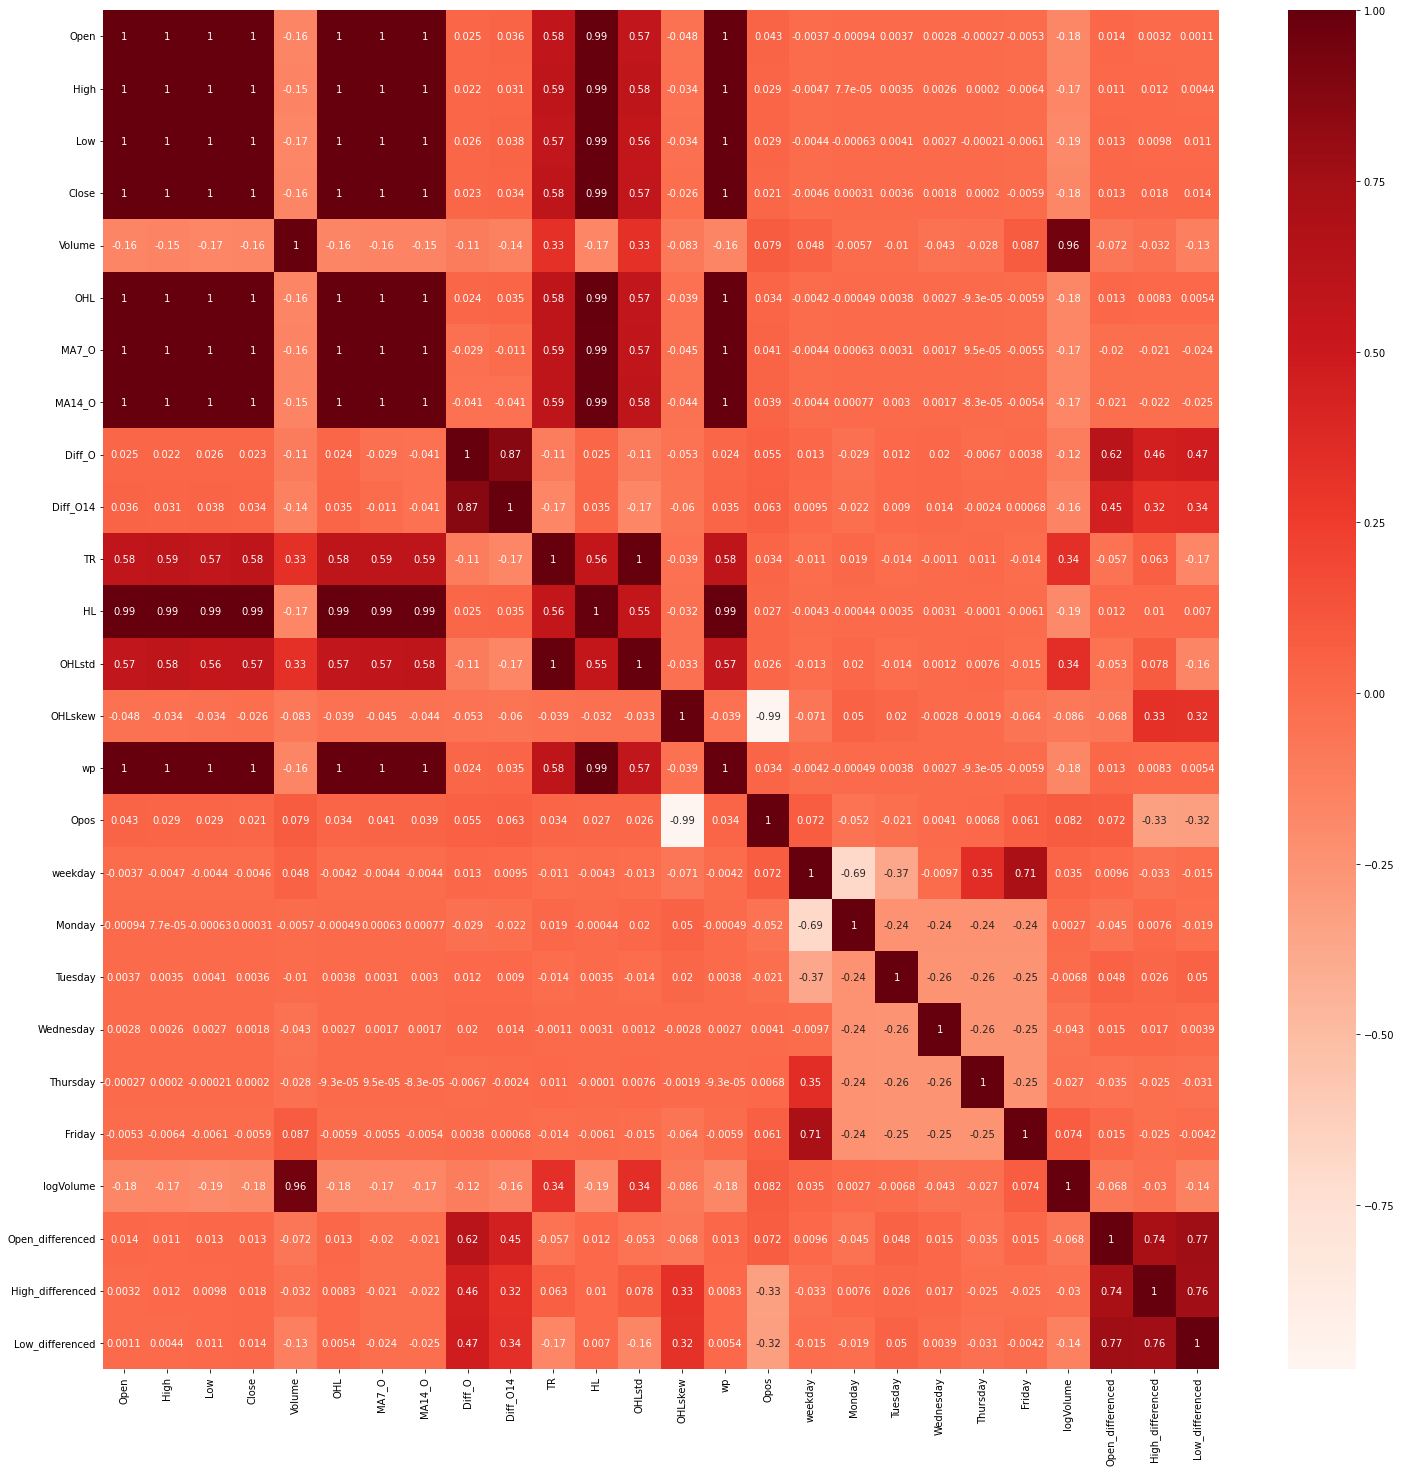

In [32]:
plt.figure(figsize=(25,25))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [33]:
labels = train_df['Close']
features= train_df.drop(['Close', 'Volume','Date' ,'weekday', 'logVolume'], axis = 1)

Attempting 4 models - Random Forest, XGBoost, Linear Regression

In [34]:
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 80, random_state = 42)# Train the model on training data
rf.fit(features, labels)


RandomForestRegressor(n_estimators=80, random_state=42)

Random Forest gives an RMSE of around 11

In [35]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(features, labels)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

XGBoost gives an RMSE of around 15

In [36]:
from sklearn.neighbors import KNeighborsRegressor

knn5 = KNeighborsRegressor(n_neighbors = 5)
knn5.fit(features, labels)

KNeighborsRegressor()

In [37]:

regr = linear_model.LinearRegression()
regr.fit(features, labels)


LinearRegression()

Linear Regression gives an RMSE of around 7.4. Hence, we will use LR for prediction

In [38]:
test_df = test_df.drop('Close', axis = 1)
test_features= test_df.drop(['Volume', 'Date', 'weekday', 'logVolume'], axis = 1)
test_df['Close'] = regr.predict(test_features)

final_df = test_df[['Date', 'Close']]
final_df.to_csv('submission.csv')